In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import MinMaxScaler

In [2]:
df = pd.read_csv('cardio_train.csv',  delimiter=';')

In [3]:
df

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
69995,99993,19240,2,168,76.0,120,80,1,1,1,0,1,0
69996,99995,22601,1,158,126.0,140,90,2,2,0,0,1,1
69997,99996,19066,2,183,105.0,180,90,3,1,0,1,0,1
69998,99998,22431,1,163,72.0,135,80,1,2,0,0,0,1


# Information about the data :

Source : https://www.kaggle.com/datasets/sulianova/cardiovascular-disease-dataset

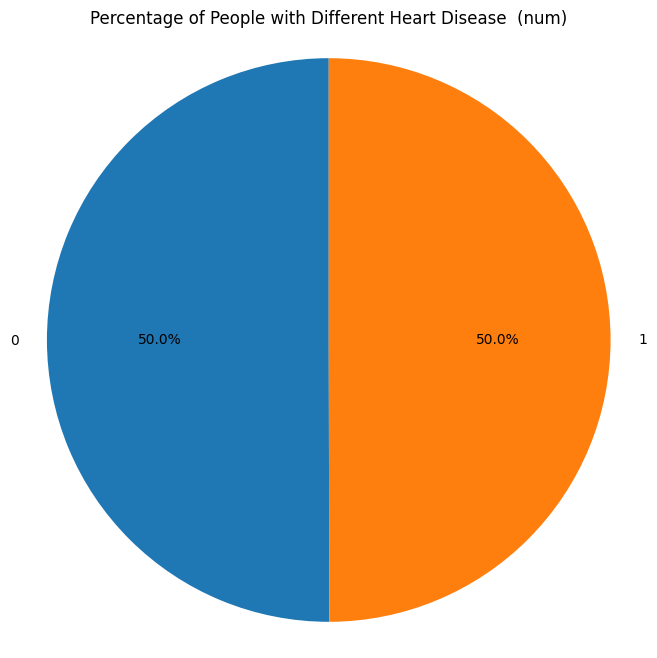

In [4]:
num_counts = df['cardio'].value_counts()

# Plot a pie chart
plt.figure(figsize=(8, 8))
plt.pie(num_counts, labels=num_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Percentage of People with Different Heart Disease  (num)')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

Dataset has proper distribution of target variables. 

# Splitting the dataset

In [5]:
data = df.drop(columns=['cardio'])

X = data.drop(columns=['id'])
y = df['cardio']  # Target variable

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [6]:
X_train

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active
68681,20417,1,160,64.0,120,90,3,1,0,0,1
19961,22690,2,167,65.0,120,80,3,3,0,0,0
11040,22784,1,160,66.0,120,90,1,1,0,0,1
27673,22648,1,163,55.0,125,90,3,1,0,0,1
22876,21712,1,158,85.0,150,80,3,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
37194,16001,2,170,75.0,150,80,1,1,1,0,1
6265,23209,2,162,73.0,160,90,1,1,0,0,1
54886,23589,1,169,74.0,120,80,1,1,0,0,1
860,18227,1,167,70.0,120,80,1,1,0,0,0


In [7]:
y_train

68681    1
19961    0
11040    1
27673    1
22876    1
        ..
37194    1
6265     1
54886    0
860      0
15795    0
Name: cardio, Length: 49000, dtype: int64

Normalizing the dataset:

In [8]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Training the model

In [9]:
param_grid = {
    'n_estimators': [100, 300, 500],          # Number of trees
    'max_depth': [None, 10, 20, 30],         # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],         # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],           # Mi nimum number of samples required to be at a leaf node
    'class_weight': ['balanced', None],      # Handle class imbalance
}

In [10]:
from sklearn.model_selection import RandomizedSearchCV

random_search = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_distributions=param_grid,
    n_iter=20,  # Test only 20 random combinations instead of all
    cv=3,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)
random_search.fit(X_train_scaled, y_train)
print("Best Parameters:", random_search.best_params_)


Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best Parameters: {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 10, 'class_weight': 'balanced'}


In [11]:


# Train a new model using the best parameters
best_rf_model = random_search.best_estimator_
y_pred_tuned = best_rf_model.predict(X_test_scaled)

# Evaluate the tuned model
print("Tuned Accuracy:", accuracy_score(y_test, y_pred_tuned))
print("Classification Report:\n", classification_report(y_test, y_pred_tuned))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_tuned))


Tuned Accuracy: 0.7392380952380952
Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.79      0.75     10461
           1       0.77      0.69      0.73     10539

    accuracy                           0.74     21000
   macro avg       0.74      0.74      0.74     21000
weighted avg       0.74      0.74      0.74     21000

Confusion Matrix:
 [[8267 2194]
 [3282 7257]]


# Improving the model

Feature Engineering

In [12]:
import pandas as pd
import numpy as np

feature_importances = best_rf_model.feature_importances_
feature_names = X_train.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

print(feature_importance_df)  # View feature importance


        Feature  Importance
4         ap_hi    0.453111
5         ap_lo    0.193246
0           age    0.144428
6   cholesterol    0.089071
3        weight    0.054916
2        height    0.029610
7          gluc    0.013966
10       active    0.007381
8         smoke    0.005271
1        gender    0.004958
9          alco    0.004042


Age | Objective Feature | age | int (days)

Height | Objective Feature | height | int (cm) |

Weight | Objective Feature | weight | float (kg) |

Gender | Objective Feature | gender | categorical code |

Systolic blood pressure | Examination Feature | ap_hi | int |

Diastolic blood pressure | Examination Feature | ap_lo | int |

Cholesterol | Examination Feature | cholesterol | 1: normal, 2: above normal, 3: well above normal |

Glucose | Examination Feature | gluc | 1: normal, 2: above normal, 3: well above normal |

Smoking | Subjective Feature | smoke | binary |

Alcohol intake | Subjective Feature | alco | binary |

Physical activity | Subjective Feature | active | binary |

Presence or absence of cardiovascular disease | Target Variable | cardio | binary |

Systolic blood pressure has the highest importance. As per importance, certain features like smoking are suggested to be dropped. However, this must be thoroughly examined. For now, we are going to compute the performance of a machine learning model that uses only the values with higher importance.

# Next round of experiments start here

In [9]:
df = pd.read_csv('cardio_train.csv',  delimiter=';')

Dropping those features reduced the accuracy. Now, need to combine those features into something useful.
Height and weight can be combined into BMI.

BMI = weight/(height)^2

In [10]:
df['lifestyle_risk_weighted'] = (df['smoke'] * 2) + (df['alco'] * 1.5) + ((1 - df['active']) * 1)


In [11]:
df

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,lifestyle_risk_weighted
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0,0.0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1,0.0
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1,1.0
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1,0.0
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69995,99993,19240,2,168,76.0,120,80,1,1,1,0,1,0,2.0
69996,99995,22601,1,158,126.0,140,90,2,2,0,0,1,1,0.0
69997,99996,19066,2,183,105.0,180,90,3,1,0,1,0,1,2.5
69998,99998,22431,1,163,72.0,135,80,1,2,0,0,0,1,1.0


In [12]:
print(df[['lifestyle_risk_weighted', 'cardio']].corr())

                         lifestyle_risk_weighted    cardio
lifestyle_risk_weighted                 1.000000  0.003453
cardio                                  0.003453  1.000000


In [13]:
df['age_lf']= df['age'] * df['lifestyle_risk_weighted']

In [14]:
df['BMI'] = df['weight']/((df['height']/100)**2)

In [15]:
print(df[['age_lf', 'cardio']].corr())

          age_lf    cardio
age_lf  1.000000  0.019399
cardio  0.019399  1.000000


In [16]:
df

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,lifestyle_risk_weighted,age_lf,BMI
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0,0.0,0.0,21.967120
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1,0.0,0.0,34.927679
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1,1.0,18857.0,23.507805
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1,0.0,0.0,28.710479
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0,1.0,17474.0,23.011177
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69995,99993,19240,2,168,76.0,120,80,1,1,1,0,1,0,2.0,38480.0,26.927438
69996,99995,22601,1,158,126.0,140,90,2,2,0,0,1,1,0.0,0.0,50.472681
69997,99996,19066,2,183,105.0,180,90,3,1,0,1,0,1,2.5,47665.0,31.353579
69998,99998,22431,1,163,72.0,135,80,1,2,0,0,0,1,1.0,22431.0,27.099251


In [17]:
data = df.drop(columns=['cardio','height','weight','active','smoke','alco','age','lifestyle_risk_weighted'])

X = data.drop(columns=['id'])
y = df['cardio']  # Target variable

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [18]:
X_train.head()

,gender,ap_hi,ap_lo,cholesterol,gluc,age_lf,BMI
68681,1,120,90,3,1,0.0,25.000000
19961,2,120,80,3,3,22690.0,23.306680
11040,1,120,90,1,1,0.0,25.781250
27673,1,125,90,3,1,0.0,20.700817
22876,1,150,80,3,1,0.0,34.049031


In [19]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [24]:
from sklearn.model_selection import RandomizedSearchCV
param_grid = {
    'n_estimators': [100, 300, 500, 700],  # Increase the number of trees
    'max_depth': [None, 10, 20, 30, 50],   # Test deeper trees
    'min_samples_split': [2, 5, 10, 15],   # Vary the min samples required to split a node
    'min_samples_leaf': [1, 2, 4, 8],      # Vary the min samples in a leaf node
    'class_weight': ['balanced', None],    # Handle class imbalance
    'max_features': ['sqrt', 'log2', None],  # Feature selection strategies
    'bootstrap': [True, False]  # Test both bootstrapping options
}


random_search = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_distributions=param_grid,
    n_iter=50,  # Test only 50 random combinations instead of all
    cv=3,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)
random_search.fit(X_train_scaled, y_train)
print("Best Parameters:", random_search.best_params_)


# Train a new model using the best parameters
best_rf_model = random_search.best_estimator_
y_pred_tuned = best_rf_model.predict(X_test_scaled)

# Evaluate the tuned model
print("Tuned Accuracy:", accuracy_score(y_test, y_pred_tuned))
print("Classification Report:\n", classification_report(y_test, y_pred_tuned))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_tuned))


Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best Parameters: {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 8, 'max_features': 'sqrt', 'max_depth': 20, 'class_weight': None, 'bootstrap': True}
Tuned Accuracy: 0.7321428571428571
Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.80      0.75     10461
           1       0.77      0.67      0.71     10539

    accuracy                           0.73     21000
   macro avg       0.74      0.73      0.73     21000
weighted avg       0.74      0.73      0.73     21000

Confusion Matrix:
 [[8347 2114]
 [3511 7028]]


# Trying other models

XGB Classifier

In [20]:
from xgboost import XGBClassifier
model = XGBClassifier(n_estimators=500, learning_rate=0.05, max_depth=10)
model.fit(X_train_scaled, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=500, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [21]:
y_pred_tuned = model.predict(X_test_scaled)

# Evaluate the tuned model
print("Tuned Accuracy:", accuracy_score(y_test, y_pred_tuned))
print("Classification Report:\n", classification_report(y_test, y_pred_tuned))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_tuned))

Tuned Accuracy: 0.7275238095238096
Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.78      0.74     10461
           1       0.76      0.67      0.71     10539

    accuracy                           0.73     21000
   macro avg       0.73      0.73      0.73     21000
weighted avg       0.73      0.73      0.73     21000

Confusion Matrix:
 [[8211 2250]
 [3472 7067]]


Trying CatBoost as it supposed to be better for categorical data

In [ ]:
from catboost import CatBoostClassifier
model = CatBoostClassifier(iterations=500, learning_rate=0.05, depth=10, verbose=0)
model.fit(X_train_scaled, y_train)


In [25]:
y_pred_tuned = model.predict(X_test_scaled)

# Evaluate the tuned model
print("Tuned Accuracy:", accuracy_score(y_test, y_pred_tuned))
print("Classification Report:\n", classification_report(y_test, y_pred_tuned))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_tuned))

Tuned Accuracy: 0.7346666666666667
Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.79      0.75     10461
           1       0.77      0.68      0.72     10539

    accuracy                           0.73     21000
   macro avg       0.74      0.73      0.73     21000
weighted avg       0.74      0.73      0.73     21000

Confusion Matrix:
 [[8306 2155]
 [3417 7122]]


Trying out multilayer perceptron

In [26]:
from sklearn.neural_network import MLPClassifier
model = MLPClassifier(hidden_layer_sizes=(100, 50), activation='relu', solver='adam')
model.fit(X_train_scaled, y_train)


MLPClassifier(hidden_layer_sizes=(100, 50))

In [27]:
y_pred_tuned = model.predict(X_test_scaled)

# Evaluate the tuned model
print("Tuned Accuracy:", accuracy_score(y_test, y_pred_tuned))
print("Classification Report:\n", classification_report(y_test, y_pred_tuned))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_tuned))

Tuned Accuracy: 0.7286666666666667
Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.81      0.75     10461
           1       0.78      0.65      0.71     10539

    accuracy                           0.73     21000
   macro avg       0.74      0.73      0.73     21000
weighted avg       0.74      0.73      0.73     21000

Confusion Matrix:
 [[8486 1975]
 [3723 6816]]


# CatBoost

- Need to improve model
- check if ap features are normalized
- Ensemble learning if all of the above fails

In [28]:
from catboost import CatBoostClassifier
from sklearn.model_selection import RandomizedSearchCV

param_grid = {
    'iterations': [500, 1000, 1500],  # Number of boosting iterations
    'learning_rate': [0.01, 0.03, 0.1, 0.2],  # Controls the step size
    'depth': [4, 6, 8, 10],  # Depth of the trees
    'l2_leaf_reg': [1, 3, 5, 10],  # Regularization
    'border_count': [32, 64, 128]  # Number of bins for feature quantization
}

catboost = CatBoostClassifier(verbose=0)
random_search = RandomizedSearchCV(catboost, param_grid, cv=3, scoring='accuracy', n_iter=20, n_jobs=-1)
random_search.fit(X_train_scaled, y_train)

print("Best Parameters:", random_search.best_params_)


Best Parameters: {'learning_rate': 0.03, 'l2_leaf_reg': 3, 'iterations': 500, 'depth': 6, 'border_count': 128}


In [33]:
from catboost import CatBoostClassifier
model = CatBoostClassifier(learning_rate= 0.03, l2_leaf_reg= 3, iterations= 500, depth= 6, border_count= 128)
model.fit(X_train_scaled, y_train)


0:	learn: 0.6849477	total: 14.9ms	remaining: 7.42s
1:	learn: 0.6772842	total: 27.5ms	remaining: 6.84s
2:	learn: 0.6700645	total: 39ms	remaining: 6.46s
3:	learn: 0.6634401	total: 52.2ms	remaining: 6.47s
4:	learn: 0.6570193	total: 63.2ms	remaining: 6.26s
5:	learn: 0.6509932	total: 77.1ms	remaining: 6.35s
6:	learn: 0.6454912	total: 89.1ms	remaining: 6.28s
7:	learn: 0.6403601	total: 103ms	remaining: 6.35s
8:	learn: 0.6356619	total: 117ms	remaining: 6.4s
9:	learn: 0.6311744	total: 131ms	remaining: 6.41s
10:	learn: 0.6268744	total: 144ms	remaining: 6.41s
11:	learn: 0.6229080	total: 158ms	remaining: 6.41s
12:	learn: 0.6191117	total: 172ms	remaining: 6.43s
13:	learn: 0.6154865	total: 187ms	remaining: 6.5s
14:	learn: 0.6120912	total: 199ms	remaining: 6.44s
15:	learn: 0.6089721	total: 213ms	remaining: 6.44s
16:	learn: 0.6060065	total: 229ms	remaining: 6.51s
17:	learn: 0.6032175	total: 244ms	remaining: 6.53s
18:	learn: 0.6006418	total: 261ms	remaining: 6.62s
19:	learn: 0.5982336	total: 273ms	rema

In [35]:
accuracy = model.score(X_test_scaled, y_test)
print("Accuracy:", accuracy)


Accuracy: 0.7347619047619047


In [36]:
from sklearn.metrics import accuracy_score

y_pred = model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)

print("Accuracy:", accuracy)


Accuracy: 0.7347619047619047
